# PBMCs with the cNMF Wrapper
Quick demo of how to use the wrapper around cNMF on the PBMC dataset.

This wrapper allows to use the cNMF code seamlessly inside python code, 
just calling a few methods on the wrapper object (as oppposed to explicit command line execution of the original code).
Overall here's the recipe:
- instantiate the Wrapper object
- `.prepare()` to load and transform the data
- `.factorize()` to do the cNMF 
- `.consensus()` to merge the different NMF runs
- `.load_results()` to get the NMF components and usages


Results should be analogous to `analyzse_pbmc_example_data.ipynb`

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import scanpy as sc
import os
import pandas as pd
from cnmfwrapper import cNMFWrapper
if not os.path.exists('example_PBMC'):
    os.mkdir('example_PBMC')

In [3]:
! wget -O example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
! tar -zxvf example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz    
! mv filtered_gene_bc_matrices example_PBMC
! rm  example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz

--2019-11-15 11:04:10--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 99.86.129.102, 99.86.129.112, 99.86.129.43, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|99.86.129.102|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz’

example_PBMC/pbmc3k 100%[===================>]   7.27M  17.1MB/s    in 0.4s    

2019-11-15 11:04:10 (17.1 MB/s) - ‘example_PBMC/pbmc3k_filtered_gene_bc_matrices.tar.gz’ saved [7621991/7621991]

filtered_gene_bc_matrices/
filtered_gene_bc_matrices/hg19/
filtered_gene_bc_matrices/hg19/matrix.mtx
filtered_gene_bc_matrices/hg19/genes.tsv
filtered_gene_bc_matrices/hg19/barcodes.tsv
mv: cannot move 'filtered_gene_bc_matrices' to 'example_PBMC/filtered_gene_bc_matrices': Directory not empty


loading the data

In [4]:
adata = sc.read_10x_mtx('example_PBMC/filtered_gene_bc_matrices/hg19')
adata.var_names_make_unique()
sc.pp.filter_cells(adata, min_genes=200) # filter cells with fewer than 200 genes
sc.pp.filter_cells(adata, min_counts=200)  # This is a weaker threshold than above. It is just to population the n_counts column in adata
sc.pp.filter_genes(adata, min_cells=3) # filter genes detected in fewer than 3 cells

adata.write_h5ad('/tmp/pbmc_nmf.h5ad')

# NMF with the Wrapper

In [5]:
W = cNMFWrapper(output_dir='/tmp/cNMF', 
                run_name='pbmc_example', 
                cnmf_executable='python ./cnmf.py',
                n_workers = 2,
                verbose=False)

In [6]:
W.prepare('/tmp/pbmc_nmf.h5ad', k_list=range(5,11), num_iter=20, num_genes=2000)
W.factorize()

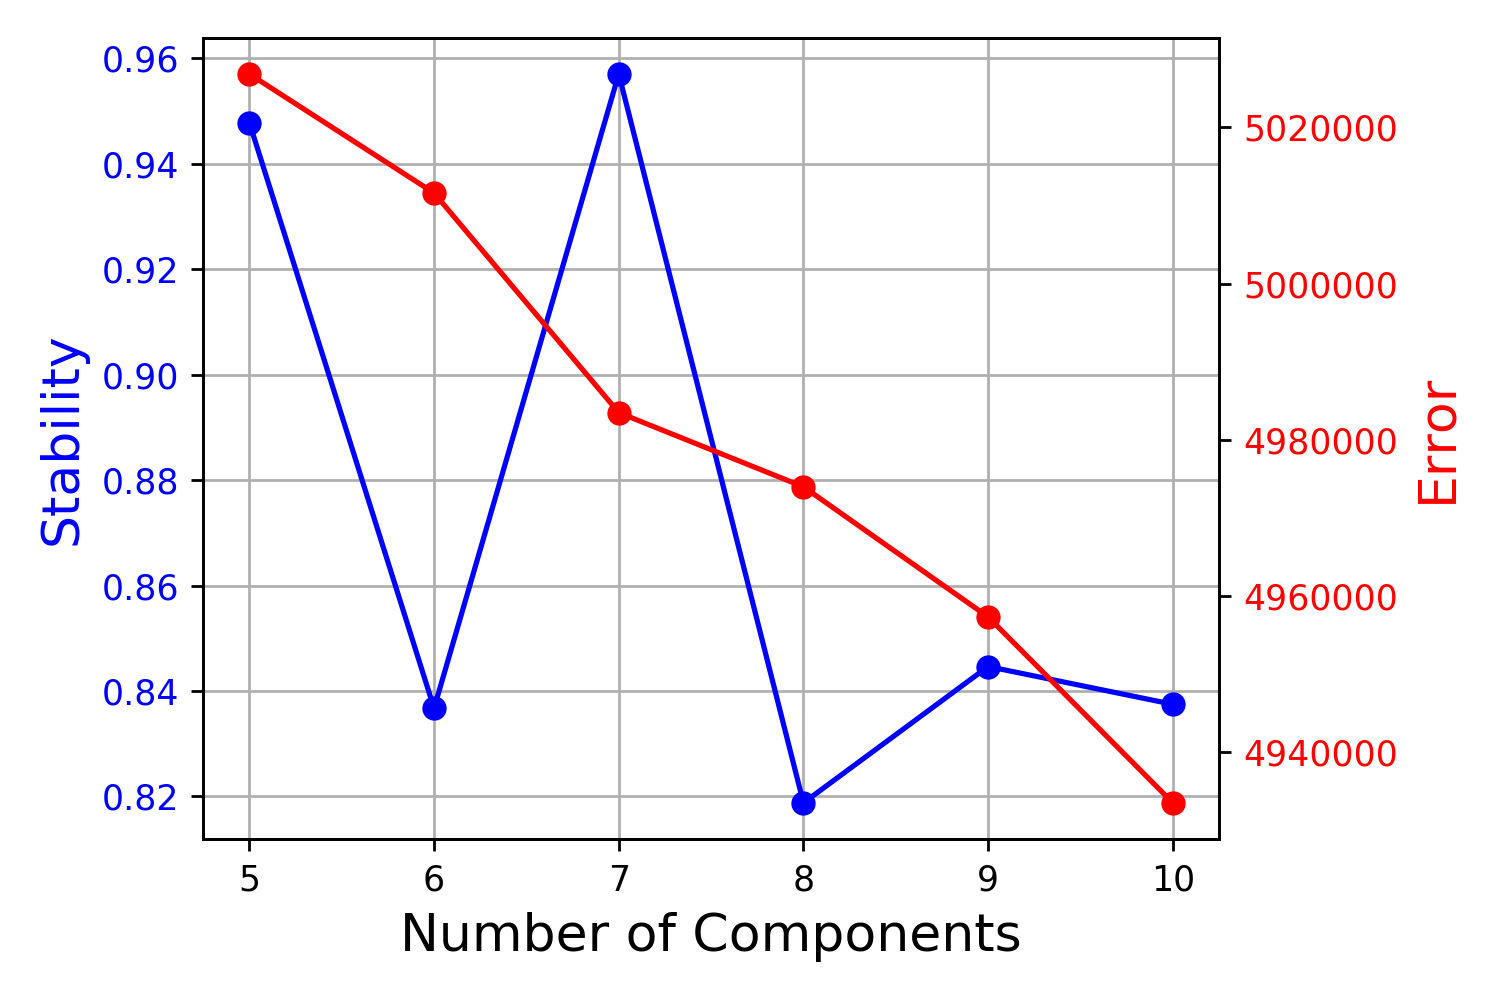

In [7]:
W.k_selection_plot()

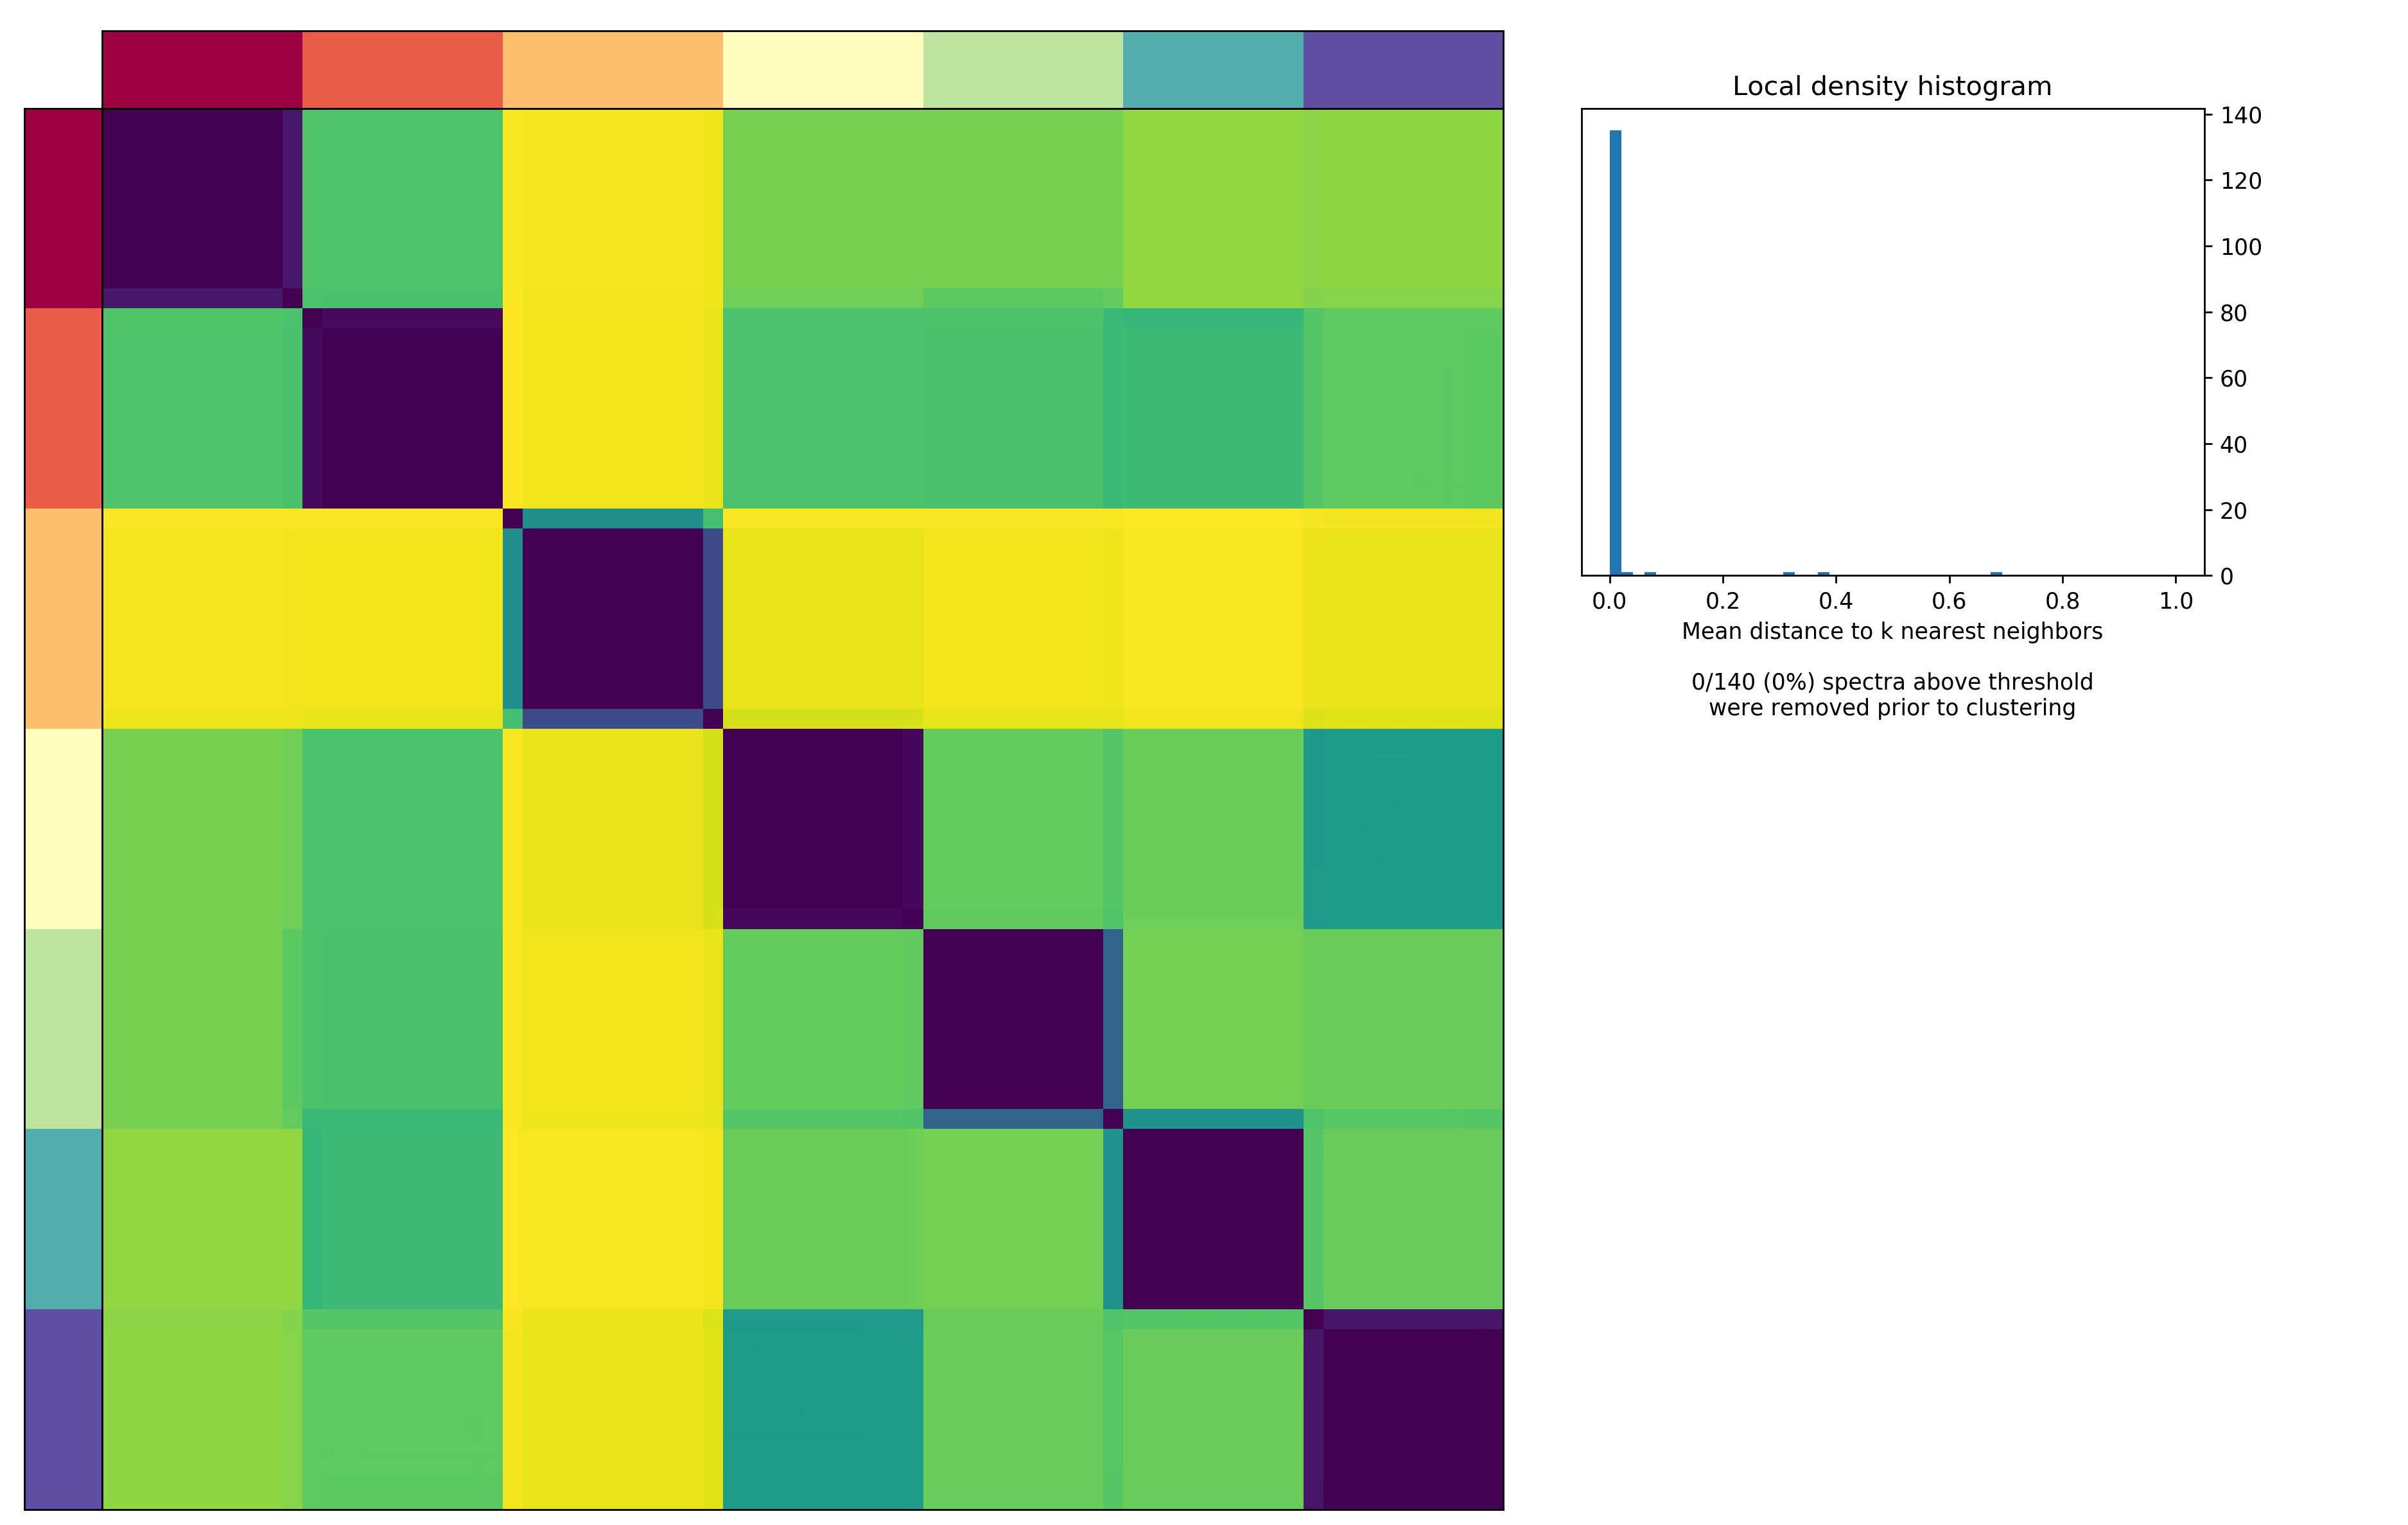

In [8]:
W.consensus(7, local_density_threshold=2)

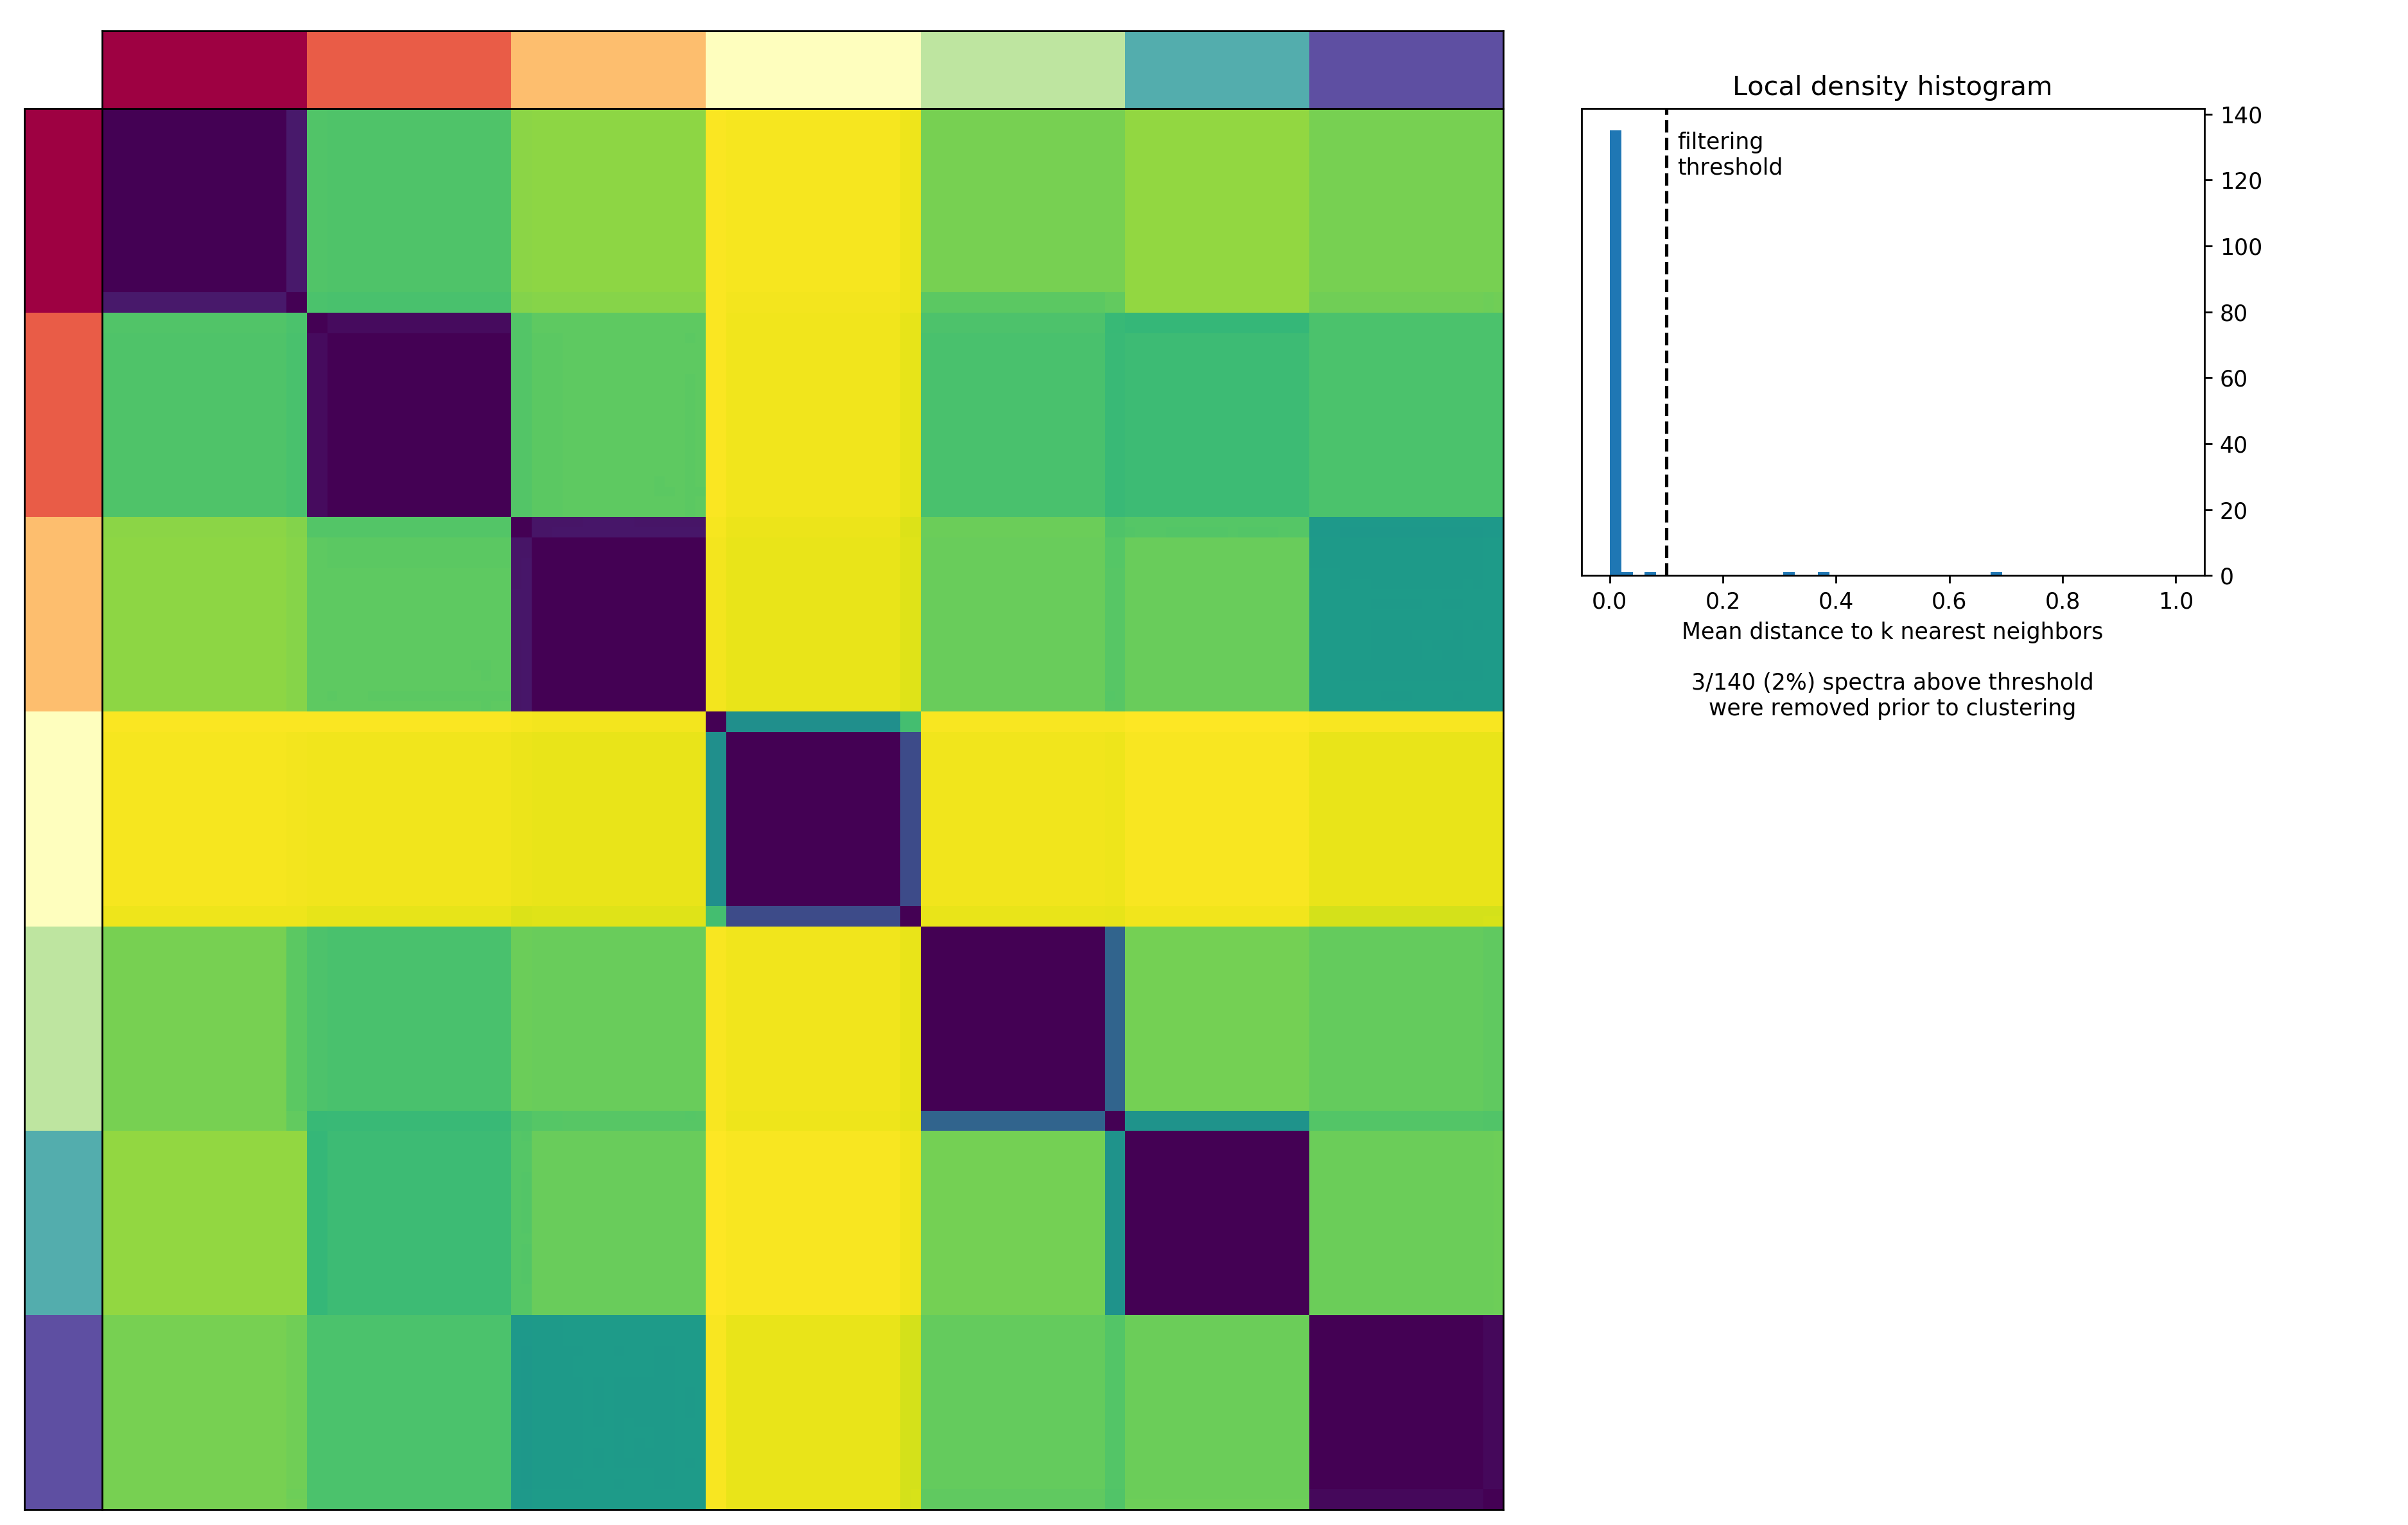

In [9]:
W.consensus(7, local_density_threshold=0.1)

In [10]:
nmf_coms, nmf_usage = W.load_results(7, local_density_threshold=0.1)
nmf_usage_norm = nmf_usage.div(nmf_usage.sum(axis=1), axis=0)

In [11]:
nmf_usage_norm.head()

,1,2,3,4,5,6,7
index,,,,,,,
AAACATACAACCAC-1,0.045656,0.859599,0.006603,0.000000,0.088142,0.000000,0.000000
AAACATTGAGCTAC-1,0.038355,0.289708,0.000000,0.000000,0.081899,0.550366,0.039671
AAACATTGATCAGC-1,0.026108,0.814184,0.007147,0.011418,0.079665,0.000000,0.061477
AAACCGTGCTTCCG-1,0.013813,0.035379,0.320968,0.023436,0.061708,0.089406,0.455290
AAACCGTGTATGCG-1,0.647056,0.099143,0.154282,0.000881,0.037774,0.060864,0.000000


# Plotting the results in UMAP
Put the results into the adata object

In [14]:
adata.obs = pd.merge(left=adata.obs, right=nmf_usage_norm, how='left', left_index=True, right_index=True)

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=10**4) ## TPT normalization
sc.pp.scale(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

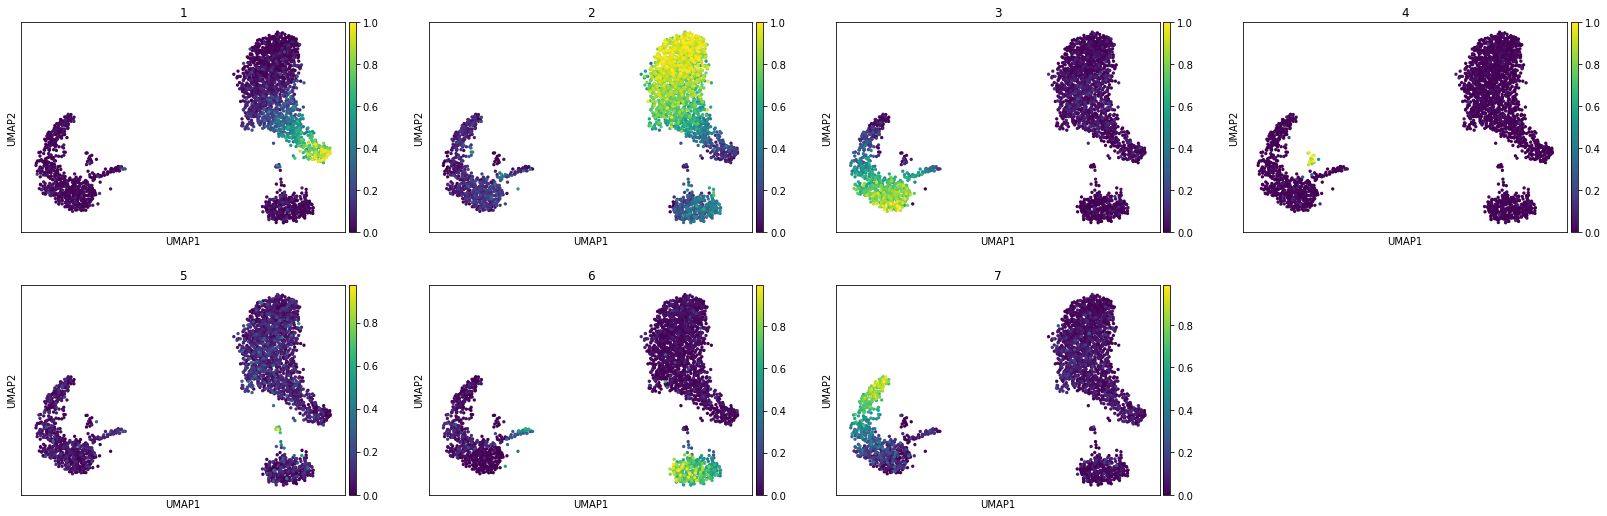

In [16]:
sc.pl.umap(adata, color=['1', '2','3','4','5','6','7'])